In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import lightgbm as lgb
import datetime
import re
from bayes_opt import BayesianOptimization

In [2]:
df = pd.read_csv('./data/FW_base_v1.csv', index_col = 0)

obj_columns = df.select_dtypes(include=['object']).columns
# Apply one-hot encoding to object columns
df = pd.get_dummies(df, columns = obj_columns, drop_first = True)
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df = df.loc[:, ~df.columns.duplicated()]

y = df.TARGET
X = df.drop('TARGET', axis = 1)
X = X.replace([np.inf, -np.inf], np.nan)
X.fillna(0.0, inplace = True)

# train, val, test : 0.9, 0.05, 0.05
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size = 0.1, random_state = 37)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size = 0.5, random_state = 37)

data_dmatrix = lgb.Dataset(data=X_train,label=y_train)

[LightGBM] [Warning] Unknown parameter: min_child_split
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] Unknown parameter: min_child_split
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3518
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 132
[LightGBM] [Warning] Unknown parameter: min_child_split
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080796 -> initscore=-2.431582
[LightGBM] [Info] Start training from score -2.431582
Training

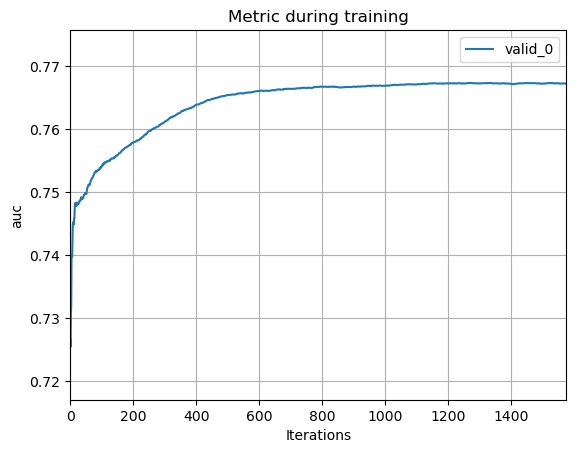

In [4]:
# FRANK 版本
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

params = {
    'objective': 'binary',
    # 'is_unbalance': 'true',
    # 'device': 'gpu',
    'n_estimators': 3000,
    'metric': 'auc',
    # 'max_bins': 63,
    'verbosity': 1,
    'n_jobs' : -1, 
    'early_stopping_round':300,
    'learning_rate' : 0.01,
    'num_leaves': 48, 
    'bagging_freq': 0,
    'subsample' : 0.9227,
    'max_depth': 7, 
    'min_child_split': 40,
    'min_split_gain': 0.4466,
    'reg_alpha': 0.9836, 
    'reg_lambda': 0.1099, 
    'scale_pos_weight': 14,
    'colsample_bytree': 0.7,
}

evals_result = {}

start_time = time.time()

gbm = lgb.LGBMClassifier(**params)
gbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[lgb.record_evaluation(evals_result)],
)

end_time = time.time()
execution_time = end_time - start_time


# After training
# for iteration, auc_values in enumerate(evals_result['valid_0']['auc'], start=1):
#     if iteration % 10 == 0:  # Print every 10 iterations
#         print(f'迭代 {iteration}: AUC = {auc_values:.4f}')

print("\n程式執行花費的时间：", round(execution_time, 2), "秒")
print("完成时间:", datetime.datetime.now())


# Plot the recorded evaluation metric (AUC)
lgb.plot_metric(evals_result, metric='auc')
plt.show()

In [5]:
y_pred = gbm.predict_proba(X_test)
roc_auc_score(y_test, y_pred[:,1])

[LightGBM] [Warning] Unknown parameter: min_child_split
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


0.7438012890084151

In [ ]:
y_pred_prob = gbm.predict_proba(X_val)
y_pred_prob = y_pred_prob[:,1]
fpr, tpr, thresh = metrics.roc_curve(y_val, y_pred_prob)
auc = metrics.roc_auc_score(y_val, y_pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label="val = %0.2f" % roc_auc)

y_pred_prob = gbm.predict_proba(X_test)
y_pred_prob = y_pred_prob[:,1]
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.title('AUC')
plt.plot(fpr, tpr, 'b', label='test = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Pipeline 寫法 (Z-score & LGBMClassfier) => 成效不彰

In [ ]:
# params = {
#             'boosting_type': 'gbdt',
#             'objective': 'binary',
#             # 'scale_pos_weight' : 14,
#             'is_unbalance': 'true',
#             'device': 'gpu',
#             'max_bins': 63,
#             'n_estimators': 100,
#             'metric': 'auc',
#             'verbosity': 1
#             }
#             # 'boosting_type':'gbdt', 'class_weight':'balanced', 'colsample_bytree':1.0,
#             # 'importance_type':'split', 'learning_rate':0.01, 'max_depth':-1,
#             # 'max_bins':63,
#             # 'min_child_samples':20, 'min_child_weight':0.001, 'min_split_gain':0.0,
#             # 'n_estimators':100, 'device':'gpu', 'num_leaves':31, 'objective':"binary",
#             # 'reg_alpha':0.1, 'reg_lambda':0.1, 'silent':True, 'early_stopping_rounds': 20,
#             # 'subsample':1.0, 'subsample_freq':0}

# pipe_lgb = Pipeline([('scaler', StandardScaler()), ('lgb', lgb.LGBMClassifier(**params))])
# # pipe_lgb = Pipeline([('scaler', StandardScaler()), ('lgb', lgb.LGBMClassifier())])
# evals_result = {}

# t0 = time.time()
# pipe_lgb.fit(X_train.values, y_train.values,
#             lgb__eval_set = [(X_train.values, y_train.values), (X_test.values, y_test.values)],
#             lgb__eval_names = ['train', 'val'],
#             lgb__eval_metric = 'auc',
#             lgb__callbacks=[lgb.record_evaluation(evals_result)] 
#             )
# t1 = time.time()
# y_pred = pipe_lgb.predict(X_test)
# y_trainPred = pipe_lgb.predict(X_train)

# print('LightGBM elapse time: {}'.format(t1-t0))
# print("完成时间:", datetime.datetime.now())

# # Plot the recorded evaluation metric (AUC)
# lgb.plot_metric(evals_result, metric='auc')
# plt.show()

In [ ]:
# accuracy=accuracy_score(y_pred, y_test)
# print('LightGBM Model test accuracy score: {0:0.4f}'.format(accuracy))

# results = pipe_lgb.named_steps["lgb"].evals_result_
# epochs = len(results['train']['auc'])
# x_axis = range(0, epochs)
# acc = [np.abs(1-x) for x in results['train']['auc']]
# acc2 = [np.abs(1-x) for x in results['val']['auc']]
# fig, ax = plt.subplots()
# ax.plot(x_axis, acc, label='Train')
# ax.plot(x_axis, acc2, label='Test')
# ax.legend()
# plt.xlabel('epoch')
# plt.ylabel('accuracy rate')
# plt.title('LightGBM ACC')
# plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = gbm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0]) # 實際沒違約，預測正確
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0]) # 實際違約，預測卻沒有

In [ ]:
cm_matrix = pd.DataFrame(data=cm, columns=['Predict Positive:0', 'Predict Negative:1'], 
                                 index=['Actual Positive:0', 'Actual Negative:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
# feature_importances = pipe_lgb.steps[1][1].feature_importances_
# # Get feature names from the pipeline
# feature_names = X_train.columns

# # Sort feature importances in ascending order
# sorted_indices = np.argsort(feature_importances)[::1]
# sorted_feature_importances = feature_importances[sorted_indices]
# sorted_feature_names = feature_names[sorted_indices]

# important_indices = np.where(sorted_feature_importances != 0)[0]
# important_feature_importances = sorted_feature_importances[important_indices]
# important_feature_names = sorted_feature_names[important_indices]
# # Plotting
# plt.figure(figsize=(10, 6))
# plt.barh(range(len(important_feature_importances)), important_feature_importances, tick_label=important_feature_names)
# plt.xlabel('Feature Importance')
# plt.ylabel('Features')
# plt.title('LightGBM Classifier Feature Importances')
# plt.tight_layout()
lgb.plot_importance(gbm, max_num_features= 20, importance_type='split', xlabel= 'split') # numbers of times the feature is used in a model
plt.show()

調參工具: 貝葉斯優化

In [26]:
def lgb_evaluate(**params):
    
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    # params['max_bins'] = int(params['max_bins'])
    params['bagging_freq'] = int(params['bagging_freq'])
    
# bayes: 0.785(eta + iter) => (l1 + 12) => (num_leaves + max_depth + max_bins)
    clf = lgb.LGBMClassifier(**params, 
                         learning_rate = 0.05,
                         n_estimators = 1000,
                         nthread = 5, 
                         boosting_type='gbdt', 
                         objective='binary',
                         early_stopping_rounds = 100,
                        #  num_leaves = 31,
                         n_jobs = -1,
                         verbosity=-1)

    folds = StratifiedKFold(n_splits= 5, shuffle=True, random_state=37)
        
    test_pred_proba = []
    # test_pred_proba = np.zeros(y_test.shape[0])
    
    feats = [f for f in df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    # 4 : 1 輪流
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[feats], df['TARGET'])):
        train_x, train_y = df[feats].iloc[train_idx], df['TARGET'].iloc[train_idx]
        val_x, val_y = df[feats].iloc[valid_idx], df['TARGET'].iloc[valid_idx]
        
        clf.fit(X_train[feats], y_train, 
                eval_set = [(train_x, train_y), (val_x, val_y)], 
                eval_metric = 'auc', 
                )

        # test_pred_proba[valid_idx] = clf.predict_proba(val_x, num_iteration = clf.best_iteration_)[:, 1]
        test_pred_proba = clf.predict_proba(X_test[feats], num_iteration = clf.best_iteration_)[:, 1]
        # del train_x, train_y, val_x, val_y

    # return roc_auc_score(df['TARGET'], test_pred_proba)
    return roc_auc_score(y_test, test_pred_proba)

In [27]:
init_time = time.time()
params = {
          'num_leaves': (20, 100),
          'subsample': (0.3, 1),
          'max_depth': (6, 9),
          'reg_alpha': (.0, 1.0),
          'reg_lambda': (.0, 1.0),
          'bagging_freq': (.0, 1.0),
          'min_split_gain': (.01, 0.5),
          'min_child_weight': (20, 100)
          }
bo = BayesianOptimization(lgb_evaluate, params)
bo.maximize(init_points = 5, n_iter = 5)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

|   iter    |  target   | baggin... | max_depth | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7429    | 0.3187    | 7.697     | 66.73     | 0.2044    | 97.71     | 0.6643    | 0.8893    | 0.8966    |
| 2         | 0.7435    | 0.549     | 6.903     | 87.51     | 0.1524    | 47.3      | 0.2944    | 0.1876    | 0.5711    |
| 3         | 0.7446    | 0.5965    | 7.942     | 81.38     | 0.4551    | 87.9      | 0.9424    | 0.2835    | 0.5545    |
| 4         | 0.7423    | 0.2216    | 7.244     | 94.98     | 0.0934    | 37.99     | 0.5675    | 0.5803    | 0.7757    |
| 5         | 0.7436    | 0.6745    | 6.825     | 90.22     | 0.1569    | 37.53     | 0.4119    | 0.9453    | 0.4111    |
| 6         | 0.7456    | 0.2665    | 7.185     | 39.55     | 0.4466    | 48.45     | 0.9836    | 0.1099    | 0.9227    |
| 7         | 0.7448    